## Import necessary third-aspect Repository

In [1]:
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm
import tensorflow as tf
from keras import backend
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
def rle_decode(mask_rle, shape, color=1):
    s = mask_rle.split()
    
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
            
    for start, end in zip(starts, ends):
        img[start : end] = color
    
    return img.reshape(shape)

In [4]:
def rle_length(x):
    """
    return the length of Rle
    """
    return np.array((x.split())[1::2]).astype(np.uint8).sum()

## Preprocess the data

In [3]:
train_data = pd.read_csv("./dataset/train.csv")
sample_submission = pd.read_csv('./dataset/sample_submission.csv')

### Resize the picture and get X_train Y_train

In [5]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
rle_min = 1000
length_min = 10000
TRAIN_PATH = './dataset/train/'

train_ids = train_data['id'].unique().tolist()
test_ids = sample_submission['id'].unique().tolist()

# Get and resize train images and masks
X_train = np.zeros((train_data['id'].nunique(), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train = np.zeros((train_data['id'].nunique(), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '.png')[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis = 2)
    X_train[n] = img
    
    labels = train_data[train_data["id"] == id_]["annotation"].tolist()
    mask = np.zeros((520, 704, 1))
    for label in labels:
        if rle_min > len(label):
            rle_min = len(label)
        if length_min > rle_length(label):
            length_min = rle_length(label)
        mask += rle_decode(label, shape=(520, 704, 1), color = 1)
    mask = mask.clip(0, 1)
    mask = mask[:,:,0]

    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((sample_submission['id'].nunique(), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing test images ... ')

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TRAIN_PATH.replace('train', 'test') + id_
    img = imread(path + '.png')[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img = np.expand_dims(img, axis = 2)
    X_test[n] = img

C:\Users\Administrator\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Getting and resizing train images and masks ... 


100%|██████████| 606/606 [01:11<00:00,  8.53it/s]


Getting and resizing test images ... 


100%|██████████| 3/3 [00:00<00:00, 52.62it/s]

Done!


### Visualize the results

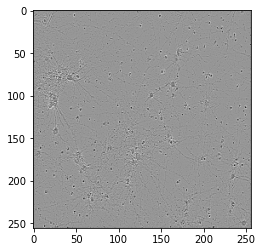

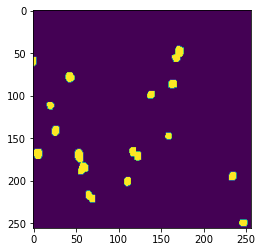

In [7]:
sample_id_num = 10
plt.imshow(X_train[sample_id_num][:,:,0], cmap = 'gray')
plt.show()
plt.imshow(Y_train[sample_id_num][:,:,0])
plt.show()

In [9]:
tf.to_int32=lambda x: tf.cast(x, tf.int32)

# Define IoU metric
def mean_iou(y_true, y_pred, smooth=1):
    intersection = backend.sum(backend.abs(y_true * y_pred), axis=[1,2,3])
    union = backend.sum(y_true,[1,2,3])+backend.sum(y_pred,[1,2,3])-intersection
    iou = backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return tf.convert_to_tensor(iou)

In [10]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

## Define the U-net network

In [8]:
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

In [14]:
# Build U-Net model
inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))
normalized_layer = Lambda(lambda x: x / 255) (inputs)

conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same') (normalized_layer)
Drop1 = Dropout(0.1) (conv1_1)
conv1_2 = Conv2D(16, (3, 3), activation='relu', padding='same') (Drop1)
pool1 = MaxPooling2D((2, 2)) (conv1_2)

conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same') (pool1)
Drop2 = Dropout(0.1) (conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same') (Drop2)
pool2 = MaxPooling2D((2, 2)) (conv2_2)

conv3_1 = Conv2D(64, (3, 3), activation='relu', padding='same') (pool2)
Drop3 = Dropout(0.2) (conv3_1)
conv3_2 = Conv2D(64, (3, 3), activation='relu', padding='same') (Drop3)
pool3 = MaxPooling2D((2, 2)) (conv3_2)

conv4_1 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool3)
Drop4 = Dropout(0.2) (conv4_1)
conv4_2 = Conv2D(128, (3, 3), activation='relu', padding='same') (Drop4)
pool4 = MaxPooling2D(pool_size=(2, 2)) (conv4_2)

conv5_1 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool4)
Drop5 = Dropout(0.3) (conv5_1)
conv5_2 = Conv2D(256, (3, 3), activation='relu', padding='same') (Drop5)

upconv1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5_2)
conca_1 = concatenate([upconv1, conv4_2])
conv6_1 = Conv2D(128, (3, 3), activation='relu', padding='same') (conca_1)
Drop6 = Dropout(0.2) (conv6_1)
conv6_2 = Conv2D(128, (3, 3), activation='relu', padding='same') (Drop6)

upconv2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6_2)
conca_2 = concatenate([upconv2, conv3_2])
conv7_1 = Conv2D(64, (3, 3), activation='relu', padding='same') (conca_2)
Drop7 = Dropout(0.2) (conv7_1)
conv7_2 = Conv2D(64, (3, 3), activation='relu', padding='same') (Drop7)

upconv3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7_2)
conca_3 = concatenate([upconv3, conv2_2])
conv8_1 = Conv2D(32, (3, 3), activation='relu', padding='same') (conca_3)
Drop8 = Dropout(0.1) (conv8_1)
conv8_2 = Conv2D(32, (3, 3), activation='relu', padding='same') (Drop8)

upconv4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8_2 )
conca_4 = concatenate([upconv4 , conv1_2], axis=3)
conv9_1 = Conv2D(16, (3, 3), activation='relu', padding='same') (conca_4)
Drop9 = Dropout(0.1) (conv9_1 )
conv9_2 = Conv2D(16, (3, 3), activation='relu', padding='same') (Drop9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9_2)

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 16) 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 256, 256, 16) 0           conv2d_22[0][0]                  
____________________________________________________________________________________________

## Train Process

In [ ]:
"""Hyperparameters"""
Patience = 10
batch_size = 5
num_epoch = 10
# Adam self-adaptive lr

In [15]:
earlystopper = EarlyStopping(patience=Patience, verbose=1)
checkpointer = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.15, batch_size=batch_size, epochs=num_epoch, 
                    callbacks=[earlystopper, checkpointer])

Train on 515 samples, validate on 91 samples
Epoch 1/10
515/515 [==============================] - 6s 11ms/step - loss: 0.5423 - dice_coefficient: 0.1964 - val_loss: 0.4917 - val_dice_coefficient: 0.1996

Epoch 00001: val_loss improved from inf to 0.49172, saving model to best_model.h5
Epoch 2/10
515/515 [==============================] - 5s 9ms/step - loss: 0.4903 - dice_coefficient: 0.1851 - val_loss: 0.4871 - val_dice_coefficient: 0.1677

Epoch 00002: val_loss improved from 0.49172 to 0.48708, saving model to best_model.h5
Epoch 3/10
515/515 [==============================] - 4s 9ms/step - loss: 0.4908 - dice_coefficient: 0.1856 - val_loss: 0.4869 - val_dice_coefficient: 0.1699

Epoch 00003: val_loss improved from 0.48708 to 0.48685, saving model to best_model.h5
Epoch 4/10
515/515 [==============================] - 5s 9ms/step - loss: 0.4900 - dice_coefficient: 0.1833 - val_loss: 0.4838 - val_dice_coefficient: 0.1809

Epoch 00004: val_loss improved from 0.48685 to 0.48376, saving m

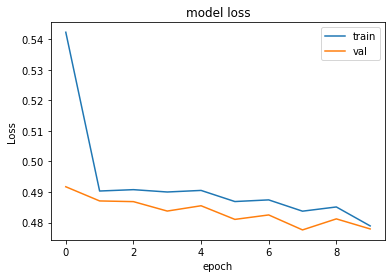

In [16]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Predict 
其中threshold的0.2可调

In [25]:
# Predict on train, val and test
threshold = 0.2
model = keras.models.load_model('best_model.h5', custom_objects={'dice_coefficient': dice_coefficient})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)
preds_test_t = (preds_test > threshold).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.transpose(np.squeeze(preds_test[i])), 
                                       (520, 704), 
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 0s 57ms/step


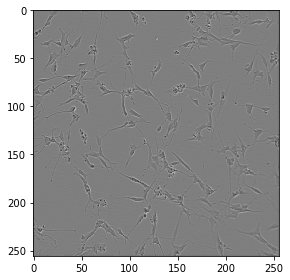

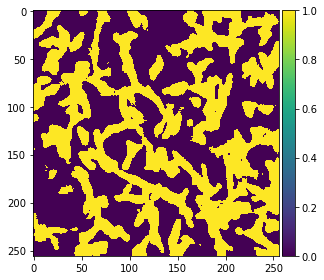

In [26]:
# Test samples
ix = random.randint(0, len(preds_test_t)-1)
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

### generate the required csv format

In [27]:
from skimage.morphology import label as labeling

C:\Users\Administrator\anaconda3\envs\tensorflow_gpu\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [28]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.65):
    lab_img = labeling(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [29]:
def rle_length_f(x):
    return np.array((x)[1::2]).astype(np.uint8).sum()

In [32]:
min = 20
min_len = 30

In [33]:
output_df = pd.DataFrame(data = None, columns = sample_submission.columns)
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n],threshold))
    for i in range(0, len(rle)):
        if len(rle[i]) < min:
            continue
        if rle_length_f(rle[i]) < min_len:
            continue
        cell_annotations = ' '.join([str(x) for x in rle[i]])
        output_df.loc[count] = id_,cell_annotations
        count +=1
output_df.to_csv('submission.csv', index = False)

In [34]:
output_df

,id,predicted
34,7ae19de7bc2a,32 27 551 28 1071 28 1591 28 2111 28 2631 28 3...
35,7ae19de7bc2a,138 19 657 21 1177 21 1698 20 2218 20 2738 20 ...
36,7ae19de7bc2a,153923 4 154442 6 154962 7 155481 9 156001 10 ...
37,7ae19de7bc2a,301083 1 301602 4 302122 4 302642 5 303161 6 3...
38,7ae19de7bc2a,22935 4 23454 7 23972 10 24492 10 25012 11 255...
39,7ae19de7bc2a,236641 1 236643 2 237159 10 237679 12 238197 1...
40,7ae19de7bc2a,260598 2 261110 3 261114 8 261630 13 262150 13...
41,7ae19de7bc2a,323011 3 323530 5 324049 6 324566 10 325085 11...
42,7ae19de7bc2a,230975 1 231492 7 232011 9 232530 11 233050 13...
43,7ae19de7bc2a,173256 6 173776 7 174295 10 174815 10 175335 1...
